# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

Qqwp


In [16]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from datetime import date, datetime
version = str(datetime.now().strftime("%H:%M(%d.%m)"))

In [18]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
# f81f72b07d784cede8af71e99ad442d9bf5851dc
import wandb

wandb.login()

wandb: Currently logged in as: ffr0nt (ffr0nt_team). Use `wandb login --relogin` to force relogin


True

In [19]:
# !wandb login --relogin

In [20]:

import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.models import resnet18


# You may add any imports you need

In [21]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)


In [22]:
act_device = "cuda" if torch.cuda.is_available() else "cpu"
act_device

'cuda'

In [23]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-07 17:58:36--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-07 17:58:37--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc02e21d3c5cb22326f9aa079433.dl.dropboxusercontent.com/cd/0/get/BwUF-_Cz6wNON9m4uAMv9lvdmjf-pLgPgTMfbsCK-ht9dkFcVDGe4msRJo9Rq-vaep3nFV2gqQeJQbGbXUnnhZqyiVEdv1_PWfMpaAZt0v4O13iNw28WjyoFPWcDtJcuzVN3YiQ-XBBif3-8KkriRGfiN4tuNy4sK41vWt0waXB-FA/file?dl=1# [following]
--2022-11-07 17:58:37--  https://uc02e21d3c5cb22326f9aa079433.dl.dropboxusercontent.com/cd/0/get/BwUF-_Cz6wNON9m4uAMv9lvdmjf-pLgPgTMfbsCK-ht9dkFcVDGe4msRJo9Rq-vaep3nFV2gqQeJQb

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [24]:
# 224 224
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        # transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.RandomHorizontalFlip(0.4),
        transforms.RandomVerticalFlip(0.4),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False) 

In [25]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

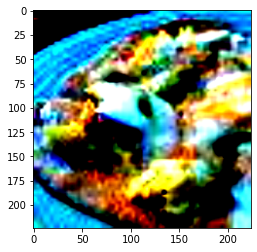

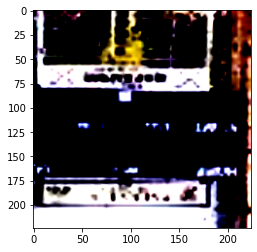

In [26]:
for batch in train_dataloader:
    images, class_nums = batch
    plt.imshow(images[15].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[2].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

### Тренировочный класс lightning



In [27]:
device = act_device
from torchmetrics.functional import accuracy
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, pretrained):
        super().__init__()
        self.model = model
        if pretrained:
          for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.fc = nn.Linear(512, 200)
        self.lr = learning_rate
        self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum = 0.9)
        # self.optimizer = torch.optim.Adam(self.model.parameters(),self.lr,eps=1e-08)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):       
        return self.model(x)


    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        x,y = train_batch
        x = x.to(device)
        y = y.to(device)
        preds = self.forward(x)
        loss_var = self.loss(preds, y)
        self.log("train_loss", loss_var, prog_bar=True)
        return loss_var

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
          preds = self.forward(x)
          loss_var = self.loss(preds, y)
          acc = accuracy(torch.argmax(preds, dim=-1).long(), y.long())
          self.log("val_loss", loss_var, prog_bar=True)
          self.log("accuracy", acc, prog_bar=True, on_epoch = True)

    # def test_epoch_end(self, test_step_outputs):  # args are defined as part of pl API
    #   dummy_input = torch.zeros(224* 224, device=self.device)
    #   model_filename = "model_final.onnx"
    #   self.to_onnx(model_filename, dummy_input, export_params=True)
    #   artifact = wandb.Artifact(name="model.ckpt", type="model")
    #   artifact.add_file(model_filename)
    #   wandb.log_artifact(artifact)
            

In [35]:
version = str(datetime.now().strftime("%H:%M(%d.%m)"))
run = wandb.init(project="iad_hw_2", name=f'resnet18 version {version}')
device = act_device
 
YourNet = resnet34(pretrained=False)
YourNet = YourNet.to(device)

wandb.watch(YourNet);
module = YourModule(YourNet, 0.001, False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
wandb.config.update({"lr": module.lr, "optimizer": module.configure_optimizers(),})

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="accuracy", mode="max")
# какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
wandb_logger = WandbLogger(log_model="all") 

# trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", callbacks=[checkpoint_callback], max_epochs = 12)

trainer = pl.Trainer(logger=wandb_logger, callbacks=[checkpoint_callback])
trainer.fit(module, train_dataloader, val_dataloader)

### Валидация результатов задания

In [28]:
from sklearn.metrics import accuracy_score

def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            pred = model.forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [38]:
artifact = run.use_artifact('ffr0nt_team/iad_hw_2/model-3mfzwj8k:v9', type='model')
artifact_dir = artifact.download()
run.join()

wandb: Downloading large artifact model-3mfzwj8k:v9, 86.15MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [ ]:
from torchvision.models import resnet34
PATH_WANDB_1 = '/content/artifacts/model-3mfzwj8k:v9/model.ckpt'
wandb_model = resnet34()
wandb_model.fc = nn.Linear(512, 200)
wandb_model.load_state_dict(torch.load(PATH_WANDB_1))
wandb_model = wandb_model.to(device)

In [41]:
accuracy = evaluate_task(wandb_model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

Оценка за это задание составит 7.26 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

### Тренировочный класс lightning

In [ ]:
device = act_device
from torchmetrics.functional import accuracy
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, pretrained):
        super().__init__()
        self.model = model
        if pretrained:
          for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.fc = nn.Linear(2048, 200)
        self.lr = learning_rate
        self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum = 0.9)
        # self.optimizer = torch.optim.Adam(self.model.parameters(),self.lr,eps=1e-08)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):       
        return self.model(x)


    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        x,y = train_batch
        x = x.to(device)
        y = y.to(device)
        preds = self.forward(x)
        loss_var = self.loss(preds, y)
        self.log("train_loss", loss_var, prog_bar=True)
        return loss_var

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
          preds = self.forward(x)
          loss_var = self.loss(preds, y)
          acc = accuracy(torch.argmax(preds, dim=-1).long(), y.long())
          self.log("val_loss", loss_var, prog_bar=True)
          self.log("accuracy", acc, prog_bar=True, on_epoch = True)


In [22]:
from torchvision.models import resnet152, ResNet152_Weights
from torchvision.models.efficientnet  import efficientnet_b4
# ==========================

version = str(datetime.now().strftime("%H:%M(%d.%m)"))
run = wandb.init(project="iad_hw_2_2", name=f'resnet152 version {version}')
device = act_device
 
YourNet = resnet152(pretrained = True)
YourNet = YourNet.to(device)

wandb.watch(YourNet);
module = YourModule(YourNet, 0.001, True)

accuracy,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▃▄▄▃▃▃▃▄▃▂▂▃▂▄▃▂▂▁▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,▁
accuracy,0.5927
epoch,0
train_loss,3.10004
trainer/global_step,3124
val_loss,3.01447


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
wandb.config.update({"lr": module.lr, "optimizer": module.configure_optimizers(),})

checkpoint_callback = pl.callbacks.ModelCheckpoint( mode="max")
wandb_logger = WandbLogger(log_model="all") 

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", callbacks=[checkpoint_callback], max_epochs = 12)

# trainer = pl.Trainer(logger=wandb_logger, callbacks=[checkpoint_callback], max_epochs = 12)
trainer.fit(module, train_dataloader, val_dataloader)

### Валидация результатов задания

In [ ]:
VAL_PATH_2 = "/content/resnet152_0,65"
val_model = resnet152()
val_model.fc = nn.Linear(2048, 200)
val_model.load_state_dict(torch.load(VAL_PATH_2))
val_model.eval()

In [48]:
accuracy = evaluate_task(val_model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

Оценка за это задание составит 4.49 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

# Аугментации

На первых моделях применял цветовые и отражающие аугментаци (помимо стандарной обрезки подходящей для используемых моделей). Однако при попытке убрать цветовые аугментации качество немного улучшилось.

Пробовал использовать различные версии ResNet с различными версиями оптимизаторов.

Эпирически выяснилось, что модели с большим номером обучались дольше (каждая эпоха шла дольше), однако и показывали лучшее качество.

Кроме того, эпирически были подтверждены слова нашего уважаемого лектора (Соколов Лучший!) касательно того, что как правило SGD с импульсом (моментумом) лучше, чем ADAM в свёрточных архитектурах.


# Задание № 1

Лучшее качество показала модель resnet18 (не смотря на то, что её базовое качество хуже нежели скажем resnet34, однако в силу того что она учиться быстрее я больше обучал это более простую модель)

https://wandb.ai/ffr0nt_team/iad_hw_2/runs/3mfzwj8k?workspace=user-ffr0nt 

# Задание №2
Тут лучшее качество показала модель с большим номером - resnet154. Это связано с тем, что базовое значение от предобученных моделей давало сильно разные результаты на валидации (Разумеется более сложные модели были лучше)

https://wandb.ai/ffr0nt_team/iad_hw_2_2/runs/spk67l44?workspace=user-ffr0nt 

(Тут страшный граффик эпох, тк после 1 эпохи сломался механизм callback и пришлось руками сохранять решения модели, посим модель будет прикрелина отдельно
)

Прикрепляю два файла с моделями, для первого и второго заданий. В первом задании модель сохранилось по странному и отказывается восстанавливаться. Второй же воскрешается вполне успешно.
